In [2]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import os

from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical 
from keras import backend as K

from sklearn.model_selection import train_test_split

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [186]:
train_data = pd.read_csv('./facial-keypoints-detection/training.csv')

In [152]:
cols, rows = 96, 96
train_data.isnull().any()
#train_data.isnull().sum(axis=0)
#train_data = train_data.dropna()
#train_data.shape

left_eye_center_x             True
left_eye_center_y             True
right_eye_center_x            True
right_eye_center_y            True
left_eye_inner_corner_x       True
left_eye_inner_corner_y       True
left_eye_outer_corner_x       True
left_eye_outer_corner_y       True
right_eye_inner_corner_x      True
right_eye_inner_corner_y      True
right_eye_outer_corner_x      True
right_eye_outer_corner_y      True
left_eyebrow_inner_end_x      True
left_eyebrow_inner_end_y      True
left_eyebrow_outer_end_x      True
left_eyebrow_outer_end_y      True
right_eyebrow_inner_end_x     True
right_eyebrow_inner_end_y     True
right_eyebrow_outer_end_x     True
right_eyebrow_outer_end_y     True
nose_tip_x                   False
nose_tip_y                   False
mouth_left_corner_x           True
mouth_left_corner_y           True
mouth_right_corner_x          True
mouth_right_corner_y          True
mouth_center_top_lip_x        True
mouth_center_top_lip_y        True
mouth_center_bottom_

In [70]:
images = [np.array(list(map(int,image.split(' ')))).reshape(cols,rows)/255 for image in train_data['Image'].values]

In [71]:
images = np.array(images)
images = images.reshape(images.shape[0],cols,rows,1)
X_train = images
#y_train = train_data[['nose_tip_x','nose_tip_y']].values
y_train = train_data.drop(['Image'],axis=1).fillna(np.nan).values
#y_trains = y_train.reshape(y_train.shape[0],2)
print("Input Shape : {0}".format(X_train.shape))
print("Output Shape : {0}".format(y_train.shape))

Input Shape : (7049, 96, 96, 1)
Output Shape : (7049, 30)


In [57]:
pos = np.where(np.isnan(y_trains[:,1])==False)
y_trains[pos,1].transpose().shape
X_train[pos].shape

(7039, 96, 96, 1)

# Deep learning

With Improved Loss Function

In [106]:
def face_loss(y_true, y_pred):
#     y = tf.constant([[1., np.nan], [np.nan, 2]])
#     x = tf.constant([[1.1, 1], [0, 2.1]])
    #_zeros = tf.zeros(y_pred.get_shape())
    _zeros = tf.multiply(tf.constant(0.0),y_pred)
    _y_true = tf.where(tf.is_nan(y_true),y_pred, y_true)
    #_loss = tf.where(tf.is_nan(y_true),_zeros, tf.square(y_pred - y_true))
    #return tf.reduce_mean(_loss, axis=-1)
    return K.mean(K.square(y_pred - _y_true), axis=-1)

y = tf.constant([[1., np.nan], [np.nan, 2]])
x = tf.constant([[1.1, 1], [0, 2.1]])
with tf.Session() as sess:
    print(sess.run(face_loss(y,x)))

[0.005      0.00499999]


In [145]:
def build_model(input_shape, output_shape):
    input_tensor = Input(shape=input_shape)
    out = Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu')(input_tensor)
    out = Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu')(out)
    out = MaxPooling2D(pool_size=(2,2))(out)
    out = Dropout(0.25)(out)
    
    out = Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu')(out)
    out = Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='linear')(out)
    out = MaxPooling2D(pool_size=(2,2), strides=(2,2))(out)
    out = Dropout(0.25)(out)

    out = Flatten()(out)
    out = Dense(256, activation = "linear")(out)
    out = Dropout(0.5)(out)
#     out = Dense(128, activation = "linear")(out)
#     out = Dropout(0.25)(out)
    output_tensor = Dense(output_shape, activation = "linear")(out)
    return input_tensor, output_tensor

In [146]:
input_shape = (cols, rows, 1)
output_shape = 30
#nb_features = 30
input_tensor, output_tensor = build_model(input_shape, output_shape)

#models = [Model(inputs=input_tensor, outputs=build_recognize(input_tensor, output_shape)) for i in range(nb_features)]    
model = Model(inputs=input_tensor, outputs=output_tensor)
model.compile(
        optimizer = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0),
        #loss = "categorical_crossentropy", 
        loss=face_loss,
        metrics=["accuracy"]
    )
# for i in range(nb_features):
#     models[i].compile(
#         optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
#         #loss = "categorical_crossentropy", 
#         loss=face_loss,
#         metrics=["accuracy"]
#     )

In [147]:
random_seed = 2
_X_train, _X_val, _y_train, _y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=random_seed)
print("Train case {0}. Val case: {1}".format(len(_X_train),len(_X_val)))

Train case 6344. Val case: 705


In [148]:
history = model.fit(_X_train, _y_train, epochs=120, batch_size=128, validation_data=(_X_val, _y_val), verbose=1)

Train on 6344 samples, validate on 705 samples
Epoch 1/120
6344/6344 [==============================] - 7s 1ms/step - loss: 381.7233 - acc: 0.2295 - val_loss: 121.6854 - val_acc: 0.0823
Epoch 2/120
6344/6344 [==============================] - 6s 927us/step - loss: 170.2845 - acc: 0.2201 - val_loss: 46.8201 - val_acc: 0.8908
Epoch 3/120
6344/6344 [==============================] - 6s 913us/step - loss: 118.0882 - acc: 0.2314 - val_loss: 30.1111 - val_acc: 0.3461
Epoch 4/120
6344/6344 [==============================] - 6s 923us/step - loss: 86.6923 - acc: 0.2377 - val_loss: 14.1505 - val_acc: 0.8908
Epoch 5/120
6344/6344 [==============================] - 6s 917us/step - loss: 62.3805 - acc: 0.2527 - val_loss: 9.2680 - val_acc: 0.1106
Epoch 6/120
6344/6344 [==============================] - 6s 920us/step - loss: 47.2442 - acc: 0.2718 - val_loss: 10.8417 - val_acc: 0.8908
Epoch 7/120
6344/6344 [==============================] - 6s 920us/step - loss: 39.2658 - acc: 0.2765 - val_loss: 8.796

6344/6344 [==============================] - 6s 909us/step - loss: 11.9502 - acc: 0.4652 - val_loss: 4.0663 - val_acc: 0.5901
Epoch 60/120
6344/6344 [==============================] - 6s 904us/step - loss: 11.9365 - acc: 0.4929 - val_loss: 6.1059 - val_acc: 0.5504
Epoch 61/120
6344/6344 [==============================] - 6s 909us/step - loss: 12.0005 - acc: 0.4849 - val_loss: 11.7529 - val_acc: 0.6426
Epoch 62/120
6344/6344 [==============================] - 6s 907us/step - loss: 12.0332 - acc: 0.4860 - val_loss: 4.4076 - val_acc: 0.6255
Epoch 63/120
6344/6344 [==============================] - 6s 908us/step - loss: 11.7565 - acc: 0.4767 - val_loss: 8.7443 - val_acc: 0.4610
Epoch 64/120
6344/6344 [==============================] - 6s 921us/step - loss: 11.9660 - acc: 0.4929 - val_loss: 10.0232 - val_acc: 0.6241
Epoch 65/120
6344/6344 [==============================] - 6s 913us/step - loss: 11.3629 - acc: 0.5115 - val_loss: 5.3967 - val_acc: 0.5319
Epoch 66/120
6344/6344 [==============

Epoch 118/120
6344/6344 [==============================] - 6s 904us/step - loss: 10.6677 - acc: 0.5032 - val_loss: 8.1323 - val_acc: 0.6511
Epoch 119/120
6344/6344 [==============================] - 6s 908us/step - loss: 10.3957 - acc: 0.4962 - val_loss: 3.9266 - val_acc: 0.4950
Epoch 120/120
6344/6344 [==============================] - 6s 910us/step - loss: 10.3842 - acc: 0.4924 - val_loss: 4.2054 - val_acc: 0.5546


# Plot Result

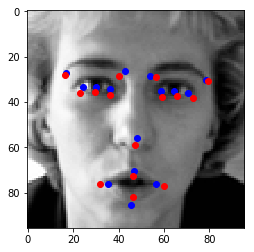

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 1
# image = train_data['Image'].values[index]
# image = np.array(list(map(int,image.split(' ')))).reshape(cols,rows)
image = images[index]
y_trues = y_trains[index,:]
#y_preds = np.array([models[i].predict(X_train[index:index+1])[0] for i in range(nb_features)])
y_preds = model.predict(X_train[index:index+1])[0]
y_trues = y_trues.reshape(15,2)
y_preds = y_preds.reshape(15,2)
plt.imshow(image.reshape(cols,rows),plt.cm.gray)
plt.scatter(y_trues[:,0],y_trues[:,1],c='b')
plt.scatter(y_preds[:,0],y_preds[:,1],c='r')

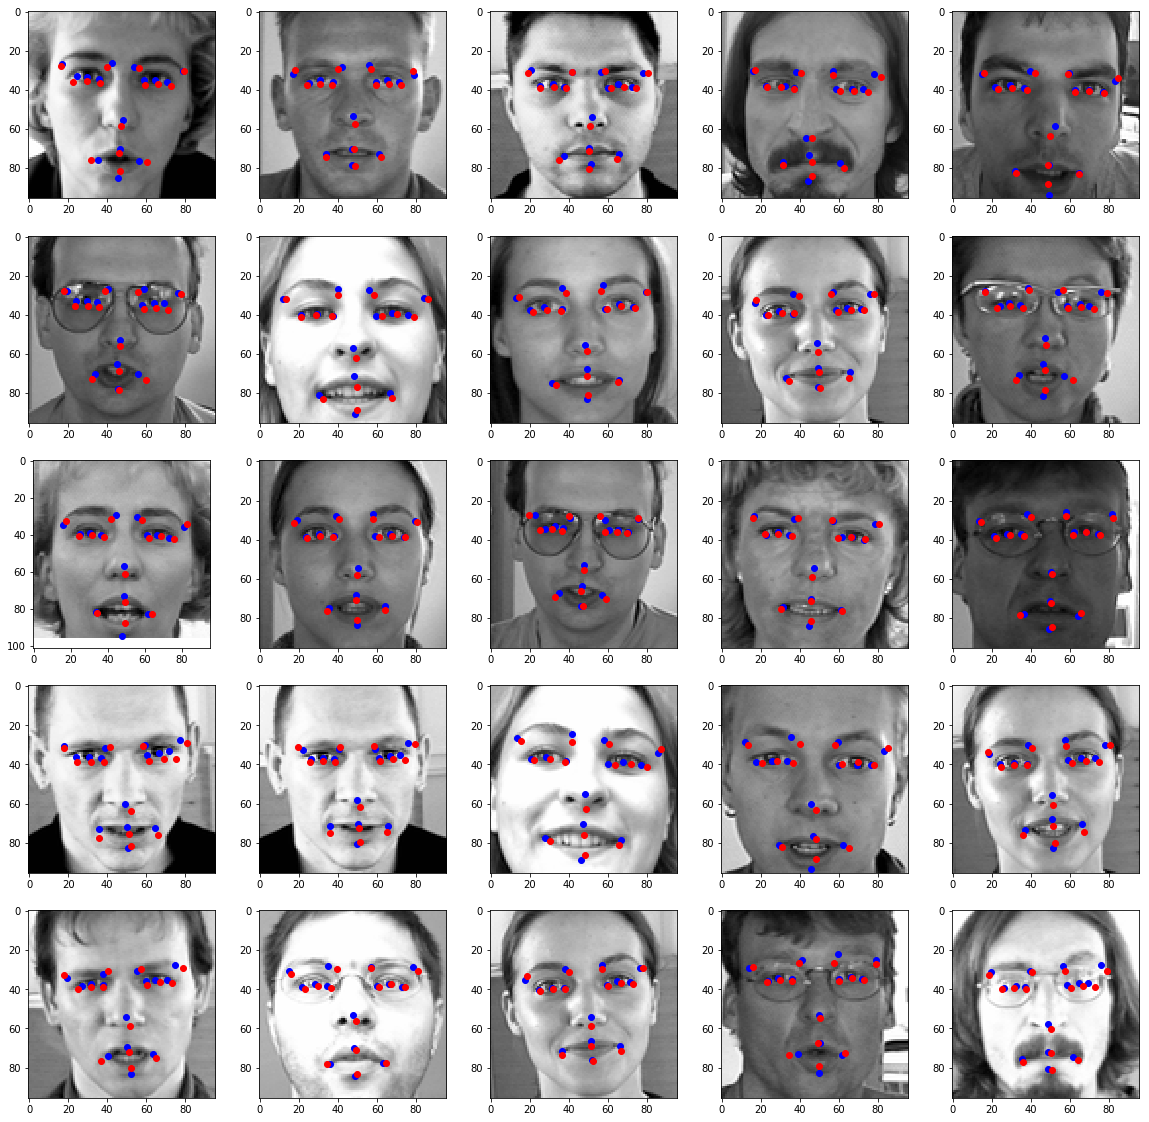

In [150]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

cols_subplot, rows_subplot = 5,5
plt.figure(1,figsize=(20,20))
samples = random.sample(range(len(images)),cols_subplot*rows_subplot)
for index in range(1,cols_subplot*rows_subplot+1):
    plt.subplot(cols_subplot,rows_subplot,index)
    #index = 1
    image = images[index]
    y_trues = y_trains[index,:]
    #y_preds = np.array([models[i].predict(X_train[index:index+1])[0] for i in range(nb_features)])
    y_preds = model.predict(X_train[index:index+1])[0]
    y_trues = y_trues.reshape(15,2)
    y_preds = y_preds.reshape(15,2)
    plt.imshow(image.reshape(cols,rows),plt.cm.gray)
    plt.scatter(y_trues[:,0],y_trues[:,1],c='b')
    plt.scatter(y_preds[:,0],y_preds[:,1],c='r')

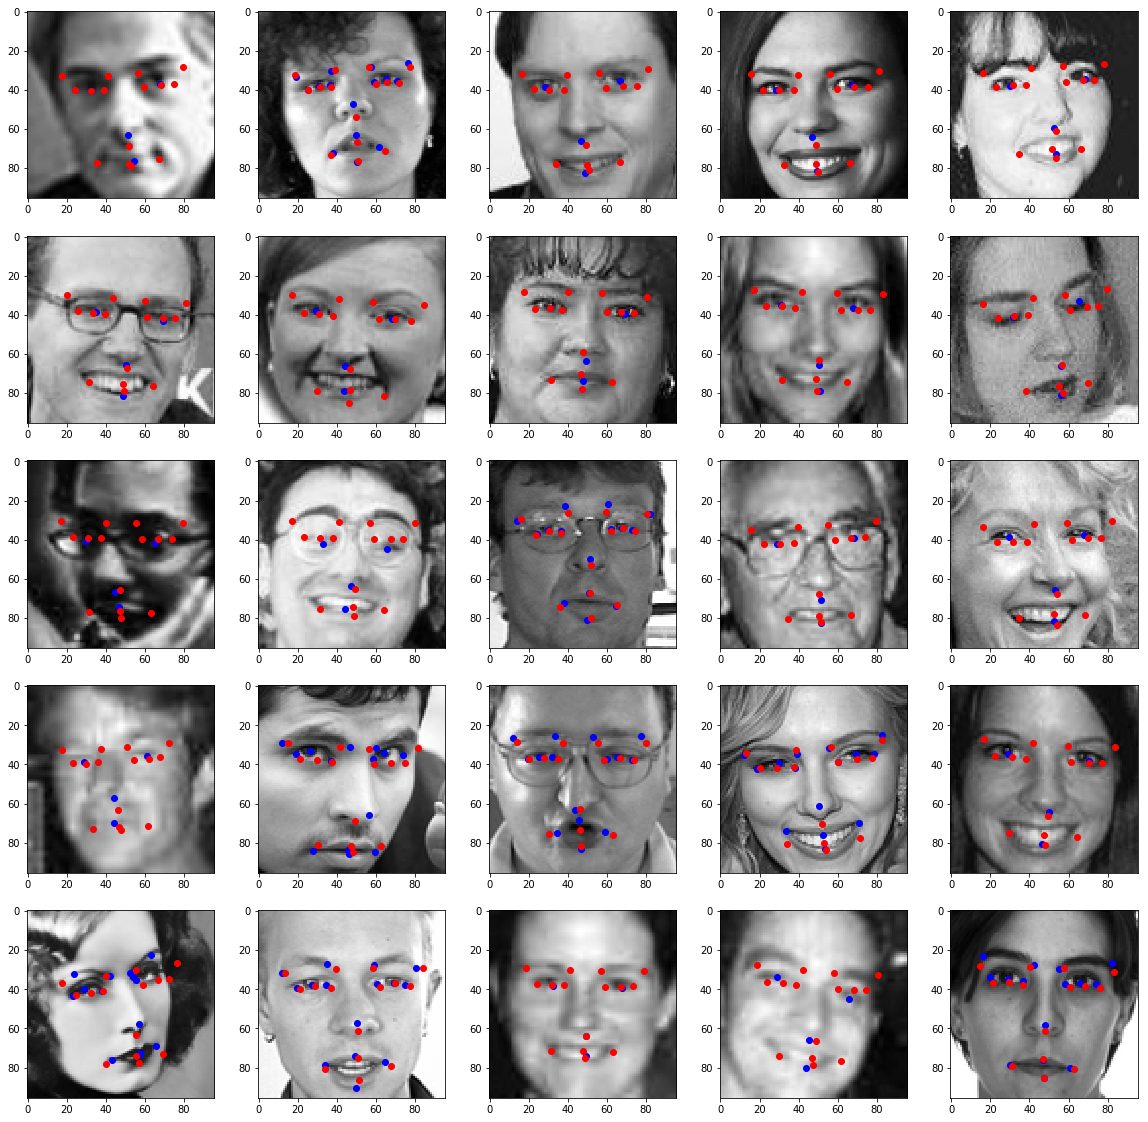

In [151]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

cols_subplot, rows_subplot = 5,5
plt.figure(figsize=(20,20))
index_samples = random.sample(range(len(images)),cols_subplot*rows_subplot)
for i in range(1,cols_subplot*rows_subplot+1):
    plt.subplot(cols_subplot,rows_subplot,i)
    #index = 1
    index = index_samples[i-1]
    image = images[index]
    y_trues = y_train[index,:]
    #y_preds = np.array([models[i].predict(X_train[index:index+1])[0] for i in range(nb_features)])
    y_preds = model.predict(X_train[index:index+1])[0]
    y_trues = y_trues.reshape(15,2)
    y_preds = y_preds.reshape(15,2)
    plt.imshow(image.reshape(cols,rows),plt.cm.gray)
    plt.scatter(y_trues[:,0],y_trues[:,1],c='b')
    plt.scatter(y_preds[:,0],y_preds[:,1],c='r')

# Explore Tensorflow

In [100]:
y = tf.constant([[1., np.nan], [np.nan, 2]])
x = tf.constant([[1.1, 1], [0, 2.1]])
#_zeros = tf.zeros(x.get_shape())
_zeros = tf.multiply(tf.constant(0.0),x)
_loss = tf.where(tf.is_nan(y),_zeros, tf.square(x-y))
with tf.Session() as sess:
    print(sess.run(_loss))

[[0.01       0.        ]
 [0.         0.00999998]]


# Predict test

In [173]:
test_data = pd.read_csv('./facial-keypoints-detection/test.csv')
result = pd.read_csv('./facial-keypoints-detection/SampleSubmission.csv')
#result['Location'] = y_pred.astype(int)
ids = pd.read_csv('./facial-keypoints-detection/IdLookupTable.csv')

In [157]:
test_images = [np.array(list(map(int,image.split(' ')))).reshape(cols,rows)/255 for image in test_data['Image'].values]

In [161]:
test_images = np.array(test_images)
test_images = test_images.reshape(test_images.shape[0],cols,rows,1)
X_test = test_images
X_test.shape

(1783, 96, 96, 1)

In [162]:
y_preds = model.predict(X_test)

In [168]:
y_preds

array([[66.95357 , 37.724968, 29.685965, ..., 70.33713 , 47.799217,
        82.10255 ],
       [68.20598 , 37.42697 , 29.025938, ..., 75.022194, 49.621384,
        85.25677 ],
       [67.908676, 38.226852, 31.260002, ..., 73.38641 , 50.087807,
        82.77596 ],
       ...,
       [68.26083 , 41.821327, 32.884735, ..., 76.801765, 47.32155 ,
        80.24187 ],
       [64.13208 , 37.761017, 29.656454, ..., 71.15032 , 45.988907,
        75.80935 ],
       [68.53035 , 41.406242, 33.077477, ..., 78.12774 , 49.730133,
        80.88666 ]], dtype=float32)

In [191]:
df_y_preds = pd.DataFrame(columns=train_data.drop(['Image'],axis=1).keys(), data=y_preds)

In [184]:
ids.iloc[0]['ImageId']

1

In [202]:
for i in range(ids.values.shape[0]):
    image_index = ids.iloc[i]['ImageId'] - 1
    feature_name = ids.iloc[i]['FeatureName']
    value = df_y_preds.iloc[image_index][feature_name]
    result.iloc[i]['Location'] = value

In [203]:
result

,RowId,Location
0,1,66
1,2,37
2,3,29
3,4,37
4,5,60
5,6,38
6,7,74
7,8,39
8,9,36
9,10,38


In [204]:
result.to_csv('./facial-keypoints-detection/submission.csv',index=False)